In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import psycopg2
import os
import sqlalchemy
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
from pulp import *
fps_colours = ['#004A9C', '#45D281', '#FEC001','#A365E0', '#5B9BD5',

               '#FF0000', '#0563C1', '#954F72']

In [2]:
def load_charging_profile(scen, cnx):
    try:
        sql_query = f"""SELECT * FROM t_charge_demand WHERE scenario_id={scen}"""
        demand = pd.read_sql_query(sql_query, cnx)
    except (Exception, psycopg2.Error) as error:
        raise(error)
    return demand

def create_alch_engine():
    db_user=os.getenv('pipe_db_user', "")
    db_pswd=os.getenv('pipe_db_pswd', "")
    db_name=os.getenv('pipe_db_name', "")
    db_host=os.getenv('pipe_db_host', "")
    db_port=os.getenv('pipe_db_port', "")
    db_conn_str = sqlalchemy.engine.URL.create(
        drivername='postgresql+psycopg2',
        username=db_user,
        password=db_pswd,
        database=db_name,
        host=db_host,
        port=db_port,
        query={'sslmode': 'require'},
        )
    cnx = sqlalchemy.create_engine(db_conn_str)
    return cnx

In [9]:
## CHANGE THE SCENARIO YOU WANT AND YOUR LOCAL PATH FOR STORING THE IMAGE

scenario = 71
yourpath = ""
date = dt.datetime(2021, 11, 16)  # Change the date you want to plot

cnx = create_alch_engine()
profiles_bau = load_charging_profile(scenario, cnx)
charge_profiles = profiles_bau.groupby('datetime').sum()['power_demand_kw'].sort_index().rename('bau')

print("Highest power demand:\n", charge_profiles.sort_values().tail(20), "\n")
print('Mean power demand:', charge_profiles.mean(), "kW")
days = len(charge_profiles)/48
print('MWh Consumed:', (charge_profiles.sum()/2)*(365/days)/1000)

Highest power demand:
 datetime
2021-11-14 23:30:00    513.648498
2021-11-15 18:00:00    517.177047
2021-11-16 17:30:00    518.411511
2021-11-14 14:00:00    526.831432
2021-11-20 22:30:00    536.582462
2021-11-15 23:30:00    539.338949
2021-11-15 22:30:00    548.166918
2021-11-17 18:00:00    566.980598
2021-11-17 17:30:00    579.521076
2021-11-20 17:30:00    580.411517
2021-11-15 23:00:00    606.078835
2021-11-16 23:30:00    613.280450
2021-11-19 23:30:00    620.668033
2021-11-17 23:30:00    630.212670
2021-11-20 23:00:00    653.425704
2021-11-19 23:00:00    657.520828
2021-11-16 22:30:00    692.432987
2021-11-17 22:30:00    710.970916
2021-11-17 23:00:00    795.367140
2021-11-16 23:00:00    878.090487
Name: bau, dtype: float64 

Mean power demand: 118.42310677321454 kW
MWh Consumed: 1037.38641533336


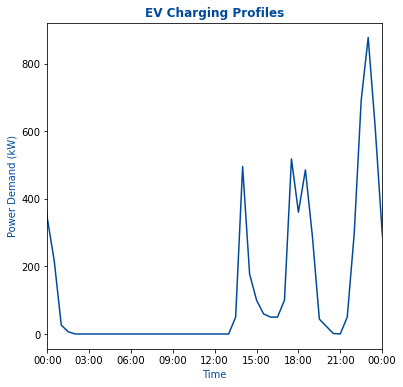

In [10]:
fig, ax = plt.subplots(
    1, figsize=(6, 6), gridspec_kw={'hspace': 0.5})

ax.set_title(
    "EV Charging Profiles",
    color=fps_colours[0], fontweight='bold')
ax.plot(
    charge_profiles.index,
    charge_profiles,
    color=fps_colours[0], label='Charge on Arrival'
    )

# ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
ax.set_ylabel('Power Demand (kW)', color=fps_colours[0])
ax.set_xlabel('Time', color=fps_colours[0])
ax.set_xlim(left=date, right=date+dt.timedelta(days=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.savefig(
    yourpath,
    bbox_inches="tight", dpi=300)